<a href="https://colab.research.google.com/github/arielnbg/Identificao-Automatizada-da-Femea-do-Aedes-aegypti-com-Redes-Neurais-Convolucionais/blob/main/TCC_CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

In [ ]:
def create_model():
    # Cria um modelo sequencial, ou seja, uma pilha linear de camadas
    model = Sequential([
        # Primeira camada convolucional com 32 filtros de tamanho 3x3, função de ativação ReLU e formato de entrada 150x150x3 (imagens RGB)
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        # Camada de pooling para reduzir as dimensões da imagem pela metade
        MaxPooling2D(2, 2),

        # Segunda camada convolucional com 64 filtros de tamanho 3x3 e função de ativação ReLU
        Conv2D(64, (3, 3), activation='relu'),
        # Segunda camada de pooling para mais uma redução de dimensionalidade
        MaxPooling2D(2, 2),

        # Terceira camada convolucional com 128 filtros de tamanho 3x3 e função de ativação ReLU
        Conv2D(128, (3, 3), activation='relu'),
        # Terceira camada de pooling
        MaxPooling2D(2, 2),

        # Quarta camada convolucional com 64 filtros de tamanho 3x3 e função de ativação ReLU
        Conv2D(64, (3, 3), activation='relu'),
        # Quarta camada de pooling
        MaxPooling2D(2, 2),

        # Quinta camada convolucional com 128 filtros de tamanho 3x3 e função de ativação ReLU
        Conv2D(128, (3, 3), activation='relu'),
        # Quinta camada de pooling
        MaxPooling2D(2, 2),

        # Camada de Flatten para transformar o tensor 3D resultante em um vetor 1D
        Flatten(),
        # Camada densa totalmente conectada com 512 neurônios e função de ativação ReLU
        Dense(512, activation='relu'),
        # Camada Dropout para desativar 50% dos neurônios durante o treinamento, ajudando a evitar overfitting
        Dropout(0.5),
        # Nova camada densa totalmente conectada com 256 neurônios e função de ativação ReLU
        Dense(256, activation='relu'),
        # Camada de saída com 2 neurônios (uma para cada classe) e ativação softmax para prever probabilidades
        Dense(1, activation='sigmoid')
    ])

    # Compila o modelo utilizando o otimizador Adam, a função de perda categorical_crossentropy e métrica de acurácia
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Para usar o modelo, basta chamar a função create_model e treinar com dados apropriados
# model = create_model()


In [ ]:
def load_data(base_dir):
    import os

    # Define os diretórios para os conjuntos de dados de treino, validação e teste
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    # Data Augmentation para o conjunto de treino
    # Aplicar transformações aleatórias para aumentar a diversidade do conjunto de dados, como rotações, translações, etc.
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normaliza os valores dos pixels para o intervalo [0, 1]
        rotation_range=40,  # Rotaciona a imagem aleatoriamente em até 40 graus
        width_shift_range=0.2,  # Desloca a imagem horizontalmente em até 20% da largura
        height_shift_range=0.2,  # Desloca a imagem verticalmente em até 20% da altura
        shear_range=0.2,  # Aplica cisalhamento na imagem
        zoom_range=0.2,  # Aplica zoom aleatório na imagem
        horizontal_flip=True,  # Inverte a imagem horizontalmente
        fill_mode='nearest'  # Define a estratégia de preenchimento dos pixels ausentes após as transformações
    )

    # Data Augmentation para os conjuntos de validação e teste
    # Apenas redimensiona os valores dos pixels para o intervalo [0, 1] sem aplicar outras transformações
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Gerador de dados para o conjunto de treino
        # Utilize apenas 100 imagens para treino e 50 para validação
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True,
        subset='training'
    )


    # Gerador de dados para o conjunto de validação
    validation_generator = val_datagen.flow_from_directory(
        val_dir,  # Diretório com as imagens de validação
        target_size=(150, 150),  # Redimensiona as imagens para 150x150 pixels
        batch_size=32,  # Tamanho do lote de imagens gerado
        class_mode='binary'  # Classes são categóricas
    )

    # Gerador de dados para o conjunto de teste
    test_generator = test_datagen.flow_from_directory(
        test_dir,  # Diretório com as imagens de teste
        target_size=(150, 150),  # Redimensiona as imagens para 150x150 pixels
        batch_size=32,  # Tamanho do lote de imagens gerado
        class_mode='binary',  # Classes são categóricas
        shuffle=False  # Não embaralha as imagens, mantendo a ordem para avaliação consistente
    )

    # Retorna os geradores de dados de treino, validação e teste
    return train_generator, validation_generator, test_generator


In [ ]:
def prepare_image(img_path, target_size=(150, 150)):
    # Importa a função de carregamento de imagens do Keras e a biblioteca NumPy

    # Carrega a imagem a partir do caminho fornecido e redimensiona para o tamanho desejado (150x150 por padrão)
    img = image.load_img(img_path, target_size=target_size)

    # Converte a imagem carregada em um array NumPy
    img_array = image.img_to_array(img)

    # Adiciona uma nova dimensão para transformar o array de (altura, largura, canais) em (1, altura, largura, canais)
    # Isso é necessário porque o modelo espera uma entrada com um lote de imagens
    img_array = np.expand_dims(img_array, axis=0)

    # Normaliza os valores dos pixels para o intervalo [0, 1]
    img_array /= 255.0

    # Retorna a imagem preparada (normalizada e com a dimensão de lote adicionada)
    return img_array

In [ ]:
def classify_image(img_path, model, class_indices):
    import numpy as np

    # Prepara a imagem para ser usada como entrada no modelo
    img_array = prepare_image(img_path)

    # Faz a previsão da classe da imagem usando o modelo fornecido
    prediction = model.predict(img_array)

    # Inverte o dicionário class_indices para mapear o índice para a classe correspondente
    class_indices = {v: k for k, v in class_indices.items()}

    # Obtém a classe prevista com base no índice de maior valor na previsão
    predicted_class = class_indices[np.argmax(prediction)]

    # Retorna a classe prevista
    return predicted_class


In [ ]:
# Define o caminho para o diretório base onde os dados do conjunto estão armazenados
base_dir = '/content/drive/MyDrive/Colab Notebooks/Comércio Eletrônico/dataset_tcc'

# Carrega os dados de treino, validação e teste utilizando a função load_data, que cria geradores para cada conjunto
train_gen, val_gen, test_gen = load_data(base_dir)

# Obtém os índices das classes a partir do gerador de treino, que mapeia os nomes das classes para índices numéricos
class_indices = train_gen.class_indices


Found 1400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [ ]:
model = create_model()

In [ ]:
# Configura o callback de Early Stopping para interromper o treinamento se a validação não melhorar por 10 épocas consecutivas
# Monitorando a métrica 'val_loss' (perda no conjunto de validação) e restaurando os melhores pesos ao final
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treina o modelo utilizando os dados de treino e validação
# Define 30 épocas de treinamento, mas o callback pode interromper antes se não houver melhoria
history = model.fit(
    train_gen,  # Gerador de dados de treino
    validation_data=val_gen,  # Gerador de dados de validação
    epochs=30,  # Número máximo de épocas para treinamento
    callbacks=[early_stopping]  # Utiliza o callback de Early Stopping para evitar overfitting
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.4948 - loss: 0.6941 - val_accuracy: 0.5333 - val_loss: 0.6919
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4943 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5193 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4919 - loss: 0.6945 - val_accuracy: 0.6167 - val_loss: 0.6910
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5251 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5166 - loss: 0.6925 - val_accuracy: 0.5867 - val_loss: 0.6877
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.5457 - loss: 0.6903 - val_accuracy: 0.5600 - val_loss: 0.6850
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5410 - loss: 0.6902 - val_accuracy: 0.6333 - val_l

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test accuracy: {test_acc}')

NameError: name 'test_gen' is not defined

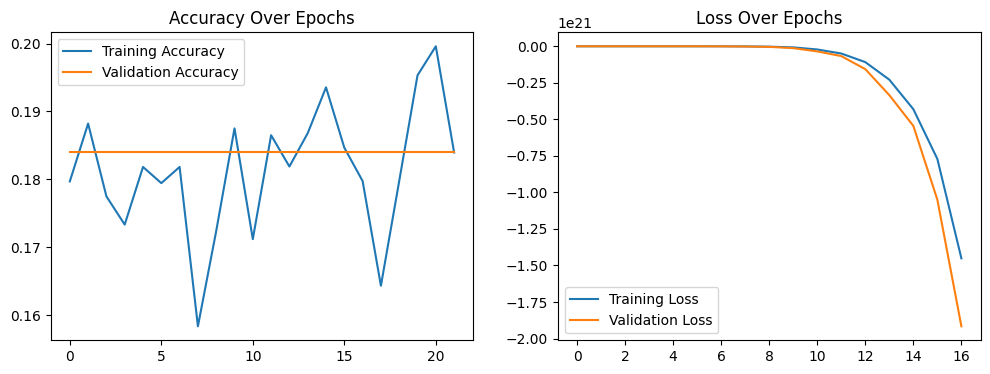

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Gera previsões para o conjunto de teste
predictions = model.predict(test_gen)

# Obtém a classe prevista para cada amostra do conjunto de teste
predicted_classes = np.argmax(predictions, axis=1)

# Obtém as classes verdadeiras do conjunto de teste
true_classes = test_gen.classes

# Obtém os rótulos das classes
class_labels = list(test_gen.class_indices.keys())

# Gera a matriz de confusão comparando as classes verdadeiras com as previstas
cm = confusion_matrix(true_classes, predicted_classes)

# Plota a matriz de confusão usando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

NameError: name 'test_gen' is not defined

In [ ]:
# Cálculo da métrica de precisão
# A precisão mede a taxa de exemplos corretamente previstos como positivos entre todos os exemplos previstos como positivos.
# A média 'macro' calcula a média da precisão de cada classe, tratando todas as classes de forma igual.
precision = precision_score(true_classes, predicted_classes, average='macro')

# Cálculo da métrica de recall (sensibilidade)
# O recall mede a taxa de exemplos corretamente previstos como positivos entre todos os exemplos que são realmente positivos.
# A média 'macro' calcula a média do recall de cada classe, tratando todas as classes de forma igual.
recall = recall_score(true_classes, predicted_classes, average='macro')

# Cálculo da métrica F1
# O F1 Score é a média harmônica entre precisão e recall, útil quando se deseja um equilíbrio entre as duas métricas.
# A média 'macro' calcula a média do F1 de cada classe, tratando todas as classes de forma igual.
f1 = f1_score(true_classes, predicted_classes, average='macro')

# Impressão dos resultados de precisão, recall e F1 Score com duas casas decimais
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Geração do relatório de classificação
# O relatório de classificação fornece métricas de precisão, recall, F1 e suporte para cada classe individualmente.
# 'target_names' são os nomes das classes obtidos a partir dos índices de classe do gerador de teste.
print("\nClassification Report:\n", classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys()))

Precision: 0.25
Recall: 0.50
F1 Score: 0.33

Classification Report:
               precision    recall  f1-score   support

   aae-femea       0.50      1.00      0.67       150
   aae-macho       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
# Importa as bibliotecas necessárias
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binariza as classes verdadeiras para uso na curva ROC
true_classes_bin = label_binarize(true_classes, classes=[0, 1])

# Obtém as probabilidades previstas para a classe positiva (supondo que a última é a classe positiva)
predicted_probs = predictions[:, 1]

# Calcula os valores de FPR (False Positive Rate) e TPR (True Positive Rate) para a curva ROC
fpr, tpr, _ = roc_curve(true_classes_bin, predicted_probs)

# Calcula a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)

# Plota a curva ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1